## SPEI CALCULATION

SPEI index is one of the mostly used indices to assess drought conditions. We want to see how was the conditions for the D48 region, what the drought a contributing element in the forest change pattern?



In [63]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pyproj
import gzip
import rasterio

Projection functions
The Evapotransipiration Dataset is in Gauss-Krüger 3rd meridian strip projection while the Precipitation is in EPSG:3034

In [64]:
def UTM_to_Gauss_Kruger(x,y):
    src_crs = pyproj.CRS("EPSG:4326")  # Google Earth projection
    target_crs = pyproj.CRS("EPSG:31467")  # Gauss-Krüger 3rd meridian strip

    # Define transformation method and parameters
    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

    # Transform coordinates
    lon, lat = x, y  # Example longitude and latitude in decimal degrees
    x, y = transformer.transform(lon, lat)  # Transform to Gauss-Krüger 3rd meridian strip
    return x, y 

def UTM_to_EPSG3034(x,y):
    src_crs = pyproj.CRS("EPSG:4326")  # Google Earth projection
    target_crs = pyproj.CRS("EPSG:3034")  # EPSG:3034 

    transformer = pyproj.Transformer.from_crs(src_crs, target_crs, always_xy=True)

    lon, lat = x, y  # Example longitude and latitude in decimal degrees
    x, y = transformer.transform(lon, lat)  # Transform to Gauss-Krüger 3rd meridian strip
    return x, y 


## Evapotranspiration

1. Below are functions to parse ASCI files to xarray.DataArray or xarray.DataSet objects.

In [65]:
# Function to get the time data from the file name.
def GetTimeFromFileName(fileDate):
    year_string = fileDate[0:4]
    year = int(year_string)
    month_string = fileDate[4:7]
    month = int(month_string)

    if (month == 1 or month==3 or month ==5 or month ==7 or month==8 or month==10 or month==12):
        return year_string +"-" + month_string +"-" + "31"
    elif (month == 4 or month==6 or month ==9 or month ==11):
        return year_string +"-" + month_string +"-" + "30"
    elif (year %4 == 0 &  month ==2):
        return year_string +"-" + month_string +"-" + "29"
    else:
        return year_string +"-" + month_string +"-" + "28"

def Parse_ASCIIFiles_To_DataSet(path , scale, unit):

    # Decompress the gzip file
    csv_files_decompressed = [gzip.open(os.path.join(file)) for file in os.scandir(path) if '.gz' in str(file)]
    
    # Initialize a list to add datasets to
    datasets = []

    for csv_file in csv_files_decompressed:
        
        # From the ET dataset documentation the upper-left cell (1st element in the ET array) has the following northing
        # and easting. We use them to construct the coordinates for the lon and lat we add resolution/2 to calculate the 
        # coordinate mid-pixel.
        northing_above = 6103501 - 1000/2
        easting_left = 3280414 + 1000/2
        
        # Get time entry
        filedate = csv_file.name.split("_")[6].split(".")[0]
        datestring = GetTimeFromFileName(filedate)

        # Read dataset
        dataset_reader = rasterio.open(csv_file, driver='AAIGrid')
        dataset = dataset_reader.read()

        # Set np.nan as nodata values and scale the data
        dataset =np.ma.masked_where(dataset == dataset_reader.nodata, dataset)
        dataset = dataset * scale

        # Construct xarray.Dataset object
        xr_dataset = xr.Dataset(
        data_vars = dict(
            et=(["time", "lat", "lon"], dataset),
        ), 
        coords=dict(
            time= np.array([datestring], dtype='datetime64'),
            lat = -np.arange(0,dataset_reader.height)*1000+northing_above,
            lon = np.arange(0,dataset_reader.width)*1000 + easting_left),
        attrs=dict(
            resolution=dataset_reader.res,
            transform = dataset_reader.transform,
            _FillValue= np.nan,
            scale = dataset_reader.scales,
            units = unit
        ))

        # Add xr ds to list 
        datasets.append(xr_dataset)

    return xr.concat(datasets,'time').sortby("time")

def Parse_ASCIIFiles_To_DataArray(path, variable_name, scale, unit):

    # Decompress the gzip file
    csv_files_decompressed = [gzip.open(os.path.join(file)) for file in os.scandir(path) if '.gz' in str(file)]
    
    # Initialize a list to add datasets to
    dataarrays = []

    for csv_file in csv_files_decompressed:
        
        # From the ET dataset documentation the upper-left cell (1st element in the ET array) has the following northing
        # and easting. We use them to construct the coordinates for the lon and lat we add resolution/2 to calculate the 
        # coordinate mid-pixel.
        northing_above = 6103501 - 1000/2
        easting_left = 3280414 + 1000/2

        # Get time entry
        filedate = csv_file.name.split("_")[6].split(".")[0]
        datestring = GetTimeFromFileName(filedate)

        # Read dataset
        dataset_reader = rasterio.open(csv_file, driver='AAIGrid')
        dataset = dataset_reader.read()
        
        # Set np.nan as nodata values and scale the data
        dataset =np.ma.masked_where(dataset == dataset_reader.nodata, dataset)
        dataset = dataset * scale

        # Construct xarray.Dataarray object
        data_array = xr.DataArray(
        data=dataset,
        dims = ['time','lat', 'lon'],
        coords=dict(
            time= np.array([datestring], dtype='datetime64'),
            lat = -np.arange(0,dataset_reader.height)*1000+northing_above,
            lon = np.arange(0,dataset_reader.width)*1000 + easting_left),
        attrs=dict(
            resolution=dataset_reader.res,
            transform = dataset_reader.transform,
            _FillValue= np.nan,
            units = unit
        ),
        name = variable_name)
        dataarrays.append(data_array)

    return xr.concat(dataarrays,'time').sortby("time")
    

In [66]:
et_merged  = Parse_ASCIIFiles_To_DataSet(path = '/work/users/my982hzao/ET_RAW', scale = 0.1, unit="mm")
et_merged

<xarray.Dataset>
Dimensions:  (time: 74, lat: 866, lon: 654)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
  * lat      (lat) float64 6.103e+06 6.102e+06 6.101e+06 ... 5.239e+06 5.238e+06
  * lon      (lon) float64 3.281e+06 3.282e+06 3.283e+06 ... 3.933e+06 3.934e+06
Data variables:
    et       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    resolution:  (1000.0, 1000.0)
    transform:   | 1000.00, 0.00, 3280414.00|\n| 0.00,-1000.00, 6103501.00|\n...
    _FillValue:  nan
    scale:       (1.0,)
    units:       mm

2. Mask to Study Region

In [67]:

lon_min, lat_min, lon_max, lat_max = [10.294189,50.307024,11.961365,50.972242]
min_GK = UTM_to_Gauss_Kruger(lon_min, lat_min)
max_GK = UTM_to_Gauss_Kruger(lon_max, lat_max)
region_GK = (et_merged.lon >= min_GK[0]) & (et_merged.lat >= min_GK[1]) & (et_merged.lon <= max_GK[0]) & (et_merged.lat <= max_GK[1])

masked_ET = et_merged.where(region_GK).dropna(dim='lon', how='all').dropna(dim='lat', how='all')
masked_ET

<xarray.Dataset>
Dimensions:  (time: 74, lat: 77, lon: 116)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
  * lat      (lat) float64 5.652e+06 5.651e+06 5.65e+06 ... 5.577e+06 5.576e+06
  * lon      (lon) float64 3.593e+06 3.594e+06 3.595e+06 ... 3.707e+06 3.708e+06
Data variables:
    et       (time, lat, lon) float64 6.0 5.9 5.9 6.2 ... 14.5 14.5 15.3 15.4
Attributes:
    resolution:  (1000.0, 1000.0)
    transform:   | 1000.00, 0.00, 3280414.00|\n| 0.00,-1000.00, 6103501.00|\n...
    _FillValue:  nan
    scale:       (1.0,)
    units:       mm

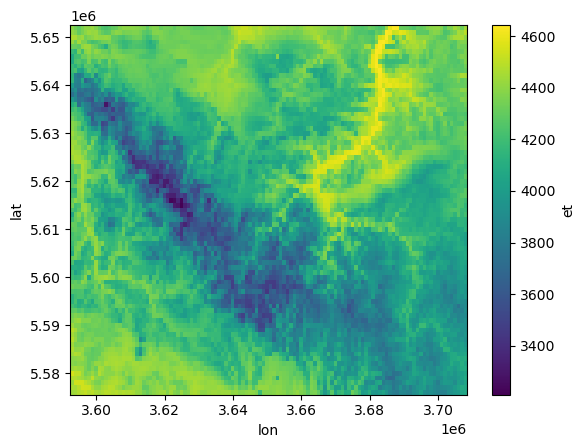

In [68]:
masked_ET.et.sum(dim='time').plot()

### 2. Preciptation

1. Fetch Precipitation dataset.

In [69]:
path = '/work/users/jn906hluu/Climate/Precipitation'
list_of_datasets = [xr.open_dataset(os.path.join(file)) for file in os.scandir(path) if '.nc' in str(file)]

pr_merged = xr.concat(list_of_datasets, dim='time')


2. The Precipitation dateset has data that aren't present in the Evapotranspiration dataset, so we will make them more consistent. 

In [70]:
# (1) resample time to be monthly sum since the et dataset is for accumulated potential evapotranspiration monthly.
pr_merged = pr_merged.sortby('time').resample(time='1M').sum()

# (2) drop unneeded vars as we only need 'pr'
pr_merged =pr_merged.drop_vars(["x_bnds","y_bnds","crs_HYRAS","number_of_stations"])

# (3) drop extra time entry which isn't in et dataset
pr_merged =pr_merged.drop(labels='2023-03-31',dim="time" )

pr_merged

/tmp/ipykernel_3267571/3836009712.py:8: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  pr_merged =pr_merged.drop(labels='2023-03-31',dim="time" )


<xarray.Dataset>
Dimensions:  (y: 1100, x: 1200, time: 74)
Coordinates:
    lon      (y, x) float64 3.427 3.441 3.454 3.467 ... 21.34 21.36 21.37 21.39
    lat      (y, x) float64 45.29 45.29 45.29 45.29 ... 55.21 55.21 55.21 55.21
  * x        (x) float32 3.5e+06 3.502e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y        (y) float32 2.1e+06 2.102e+06 2.102e+06 ... 3.198e+06 3.2e+06
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
Data variables:
    pr       (time, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/20)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    conventionsURL:            http://cfconventions.org/Data/cf-conventions/c...
    institution:               Deutscher Wetterdienst (DWD)
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc

3. Mask to Study Region

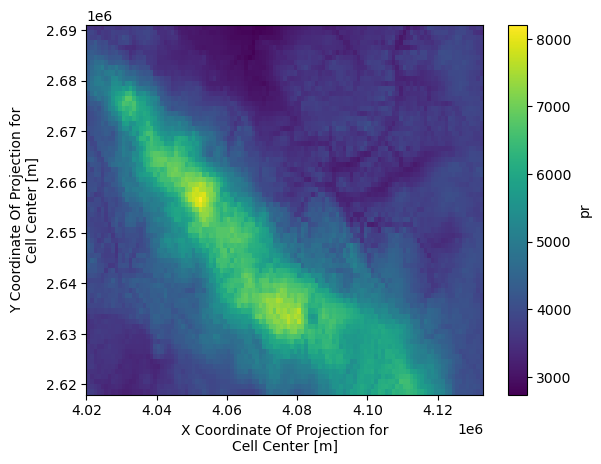

In [71]:
min_EPSG3034 = UTM_to_EPSG3034(lon_min, lat_min)
max_EPSG3034 = UTM_to_EPSG3034(lon_max, lat_max)
region_EPSG3034 = (pr_merged.x >= min_EPSG3034[0]) & (pr_merged.y >= min_EPSG3034[1]) & (pr_merged.x <= max_EPSG3034[0]) & (pr_merged.y <= max_EPSG3034[1])

masked_PR = pr_merged.where(region_EPSG3034).dropna(dim='x', how='all').dropna(dim='y', how='all')
masked_PR.pr.sum(dim='time').plot()

In [72]:
masked_PR

<xarray.Dataset>
Dimensions:  (time: 74, y: 73, x: 113)
Coordinates:
    lon      (y, x) float64 10.3 10.31 10.33 10.34 ... 11.91 11.92 11.94 11.95
    lat      (y, x) float64 50.31 50.31 50.31 50.31 ... 50.97 50.97 50.96 50.96
  * x        (x) float32 4.02e+06 4.022e+06 4.022e+06 ... 4.132e+06 4.132e+06
  * y        (y) float32 2.618e+06 2.62e+06 2.62e+06 ... 2.69e+06 2.69e+06
  * time     (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
Data variables:
    pr       (time, y, x) float32 26.0 25.2 23.3 21.9 ... 44.5 43.7 45.4 43.3
Attributes: (12/20)
    source:                    surface observations
    Conventions:               CF-1.8
    references:                https://opendata.dwd.de/climate_environment/CD...
    realization:               v5.0
    version_hyras_background:  v3.0
    project_id:                HYRAS
    ...                        ...
    conventionsURL:            http://cfconventions.org/Data/cf-conventions/c...
    institution:               Deutscher Wetterdienst (DWD)
    title:                     gridded_precipitation_dataset_(HYRAS-DE PRE)
    creation_date:             created at 2022-12-03 19:17:38
    unique_dataset_id:         DWD_HYRAS_DE_1km_pr_v5.0_2018_day_00638BA0D2
    filename:                  pr_hyras_1_2018_v5-0_de.nc

The final inconsistency is the that each dataset has a different projection, we will reproject the et dataset to pr dataset

In [73]:
# renaming dims to match pr dataset naming and the reprojection works
masked_ET = masked_ET.rename({"lon": "x", "lat": "y"})

# assigning each set's projection to it's xarray.dataset object
masked_PR.rio.write_crs("EPSG:3034", inplace=True)
masked_ET.rio.write_crs("EPSG:31467", inplace=True)

et_reprojected = masked_ET.rio.reproject_match(masked_PR)
et_reprojected

<xarray.Dataset>
Dimensions:      (x: 113, y: 73, time: 74)
Coordinates:
  * x            (x) float32 4.02e+06 4.022e+06 ... 4.132e+06 4.132e+06
  * y            (y) float32 2.618e+06 2.62e+06 2.62e+06 ... 2.69e+06 2.69e+06
  * time         (time) datetime64[ns] 2017-01-31 2017-02-28 ... 2023-02-28
    spatial_ref  int64 0
Data variables:
    et           (time, y, x) float64 5.4 5.4 5.4 5.5 ... 18.7 17.6 17.8 18.8
Attributes:
    resolution:  (1000.0, 1000.0)
    transform:   | 1000.00, 0.00, 3280414.00|\n| 0.00,-1000.00, 6103501.00|\n...
    _FillValue:  nan
    scale:       (1.0,)
    units:       mm

In [74]:
#Final et
print("ET Final")
et_reprojected = et_reprojected[["y","x","time","et"]]
print(et_reprojected.rio.crs)
print(et_reprojected.dims)
et_final = et_reprojected

#Final pr
print("PR Final")
masked_PR = masked_PR[["y","x","time","pr"]]
print(masked_PR.rio.crs)
print(masked_PR.dims)
pr_final=masked_PR

ET Final
EPSG:3034
Frozen({'y': 73, 'x': 113, 'time': 74})
PR Final
EPSG:3034
Frozen({'y': 73, 'x': 113, 'time': 74})


In [75]:
# Write to netCDF file
path = "/work/users/my982hzao/SPEI"

del pr_final.pr.attrs['grid_mapping']

et_final.to_netcdf(path+"/et_rec.nc")
pr_final.to_netcdf(path+"/pr_rec.nc")